<a href="https://colab.research.google.com/github/charithcherry/Linkedin-Job-Market-Analysis-using-ML/blob/dev-srushti/PreProcessingAndEDA_LinkedInDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

In [2]:
df = pd.read_csv("/content/sample_data/postings.csv")
df.head()

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0


In [3]:
def show_null_count(df, col):
    # Check if the column exists in the DataFrame
    if col in df.columns:
        # Calculate the number of null values in the column
        null_count = df[col].isnull().sum()
        print(f"Total null values in '{col}': {null_count}")
    else:
        print(f"Column '{col}' does not exist in the DataFrame.")


In [4]:
for column in df.columns:
    show_null_count(df, column)

Total null values in 'job_id': 0
Total null values in 'company_name': 1719
Total null values in 'title': 0
Total null values in 'description': 7
Total null values in 'max_salary': 94056
Total null values in 'pay_period': 87776
Total null values in 'location': 0
Total null values in 'company_id': 1717
Total null values in 'views': 1689
Total null values in 'med_salary': 117569
Total null values in 'min_salary': 94056
Total null values in 'formatted_work_type': 0
Total null values in 'applies': 100529
Total null values in 'original_listed_time': 0
Total null values in 'remote_allowed': 108603
Total null values in 'job_posting_url': 0
Total null values in 'application_url': 36665
Total null values in 'application_type': 0
Total null values in 'expiry': 0
Total null values in 'closed_time': 122776
Total null values in 'formatted_experience_level': 29409
Total null values in 'skills_desc': 121410
Total null values in 'listed_time': 0
Total null values in 'posting_domain': 39968
Total null v

In [5]:
def drop_column(df, col):
    # Drop the specified column if it exists, ignoring errors if it doesn't
    df = df.drop(columns=[col], errors='ignore')
    if col in df.columns:
        print(f"Column '{col}' has been dropped.")
    else:
        print(f"Column '{col}' does not exist in the DataFrame.")
    return df

In [6]:
df = drop_column(df, 'job_posting_url')
df = drop_column(df, 'application_url')
df = drop_column(df, 'application_type')
df = drop_column(df, 'formatted_experience_level')
df = drop_column(df, 'posting_domain')
df = drop_column(df, 'zip_code')

Column 'job_posting_url' does not exist in the DataFrame.
Column 'application_url' does not exist in the DataFrame.
Column 'application_type' does not exist in the DataFrame.
Column 'formatted_experience_level' does not exist in the DataFrame.
Column 'posting_domain' does not exist in the DataFrame.
Column 'zip_code' does not exist in the DataFrame.


In [7]:
df.columns

Index(['job_id', 'company_name', 'title', 'description', 'max_salary',
       'pay_period', 'location', 'company_id', 'views', 'med_salary',
       'min_salary', 'formatted_work_type', 'applies', 'original_listed_time',
       'remote_allowed', 'expiry', 'closed_time', 'skills_desc', 'listed_time',
       'sponsored', 'work_type', 'currency', 'compensation_type',
       'normalized_salary', 'fips'],
      dtype='object')

In [8]:
def convert_unix_to_ddmmyyyy(df, col):
    # Check if the column exists in the DataFrame
    if col in df.columns:
        # Attempt to convert the column to numeric, coercing errors
        df[col] = pd.to_numeric(df[col], errors='coerce')

        # Convert from milliseconds to seconds for Unix timestamps
        df[col] = pd.to_datetime(df[col] / 1000.0, unit='s', errors='coerce')

        # Format dates as 'dd-mm-yyyy', leaving NaT (Not a Time) values unchanged
        df[col] = df[col].dt.strftime('%d-%m-%Y')

        print(f"Column '{col}' has been converted to 'dd-mm-yyyy' format.")
    else:
        print(f"Column '{col}' does not exist in the DataFrame.")

    return df  # Return the modified DataFrame

In [9]:
df = convert_unix_to_ddmmyyyy(df, 'original_listed_time')
df = convert_unix_to_ddmmyyyy(df, 'listed_time')
df['original_listed_time'].head()
df['listed_time'].head()

Column 'original_listed_time' has been converted to 'dd-mm-yyyy' format.
Column 'listed_time' has been converted to 'dd-mm-yyyy' format.


,listed_time
0,17-04-2024
1,11-04-2024
2,16-04-2024
3,12-04-2024
4,18-04-2024


In [10]:
def fill_with_median(df, col):
    # Fill missing values in the specified column with the median
    df[col].fillna(df[col].median(), inplace=True)
    return df

In [11]:
df = fill_with_median(df, 'max_salary')


<ipython-input-10-6f30d73a0dc8>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [12]:
def fill_with_mean(df, col):
    # Fill missing values in the specified column with the mean
    df[col].fillna(df[col].mean(), inplace=True)
    return df

In [13]:
def fill_nulls_with_normalized_values_min_max(df, col):
    if col in df.columns:
        # Initialize the MinMaxScaler
        scaler = MinMaxScaler()

        # Normalize the column values, ignoring nulls
        # First, we need to handle nulls: we will fill them temporarily with the column mean
        temp_col = df[col].fillna(df[col].mean())

        # Reshape the data to fit the scaler (2D array expected)
        normalized_values = scaler.fit_transform(temp_col.values.reshape(-1, 1))

        # Replace the original column values with the normalized values
        # Fill nulls in the original column with the corresponding normalized values
        df[col] = df[col].fillna(pd.Series(normalized_values.flatten(), index=df.index))

        print(f"Null values in column '{col}' have been replaced with normalized values.")
    else:
        print(f"Column '{col}' does not exist in the DataFrame.")

    return df  # Return the modified DataFrame


In [14]:
df = fill_nulls_with_normalized_values_min_max(df, 'normalized_salary')

Null values in column 'normalized_salary' have been replaced with normalized values.


In [15]:
df['normalized_salary'].isnull().sum()

0

In [16]:
def calculate_time_difference(df, listed_time_col, expiry_col, new_col='time_difference'):
    if listed_time_col in df.columns and expiry_col in df.columns:
        # Ensure the specified columns are in datetime format
        df[listed_time_col] = pd.to_datetime(df[listed_time_col], errors='coerce')
        df[expiry_col] = pd.to_datetime(df[expiry_col], errors='coerce')

        # Calculate the difference and store it in the new column
        df[new_col] = df[expiry_col] - df[listed_time_col]

        print(f"Time difference calculated and stored in column '{new_col}'.")
    else:
        print(f"One or both columns '{listed_time_col}' and '{expiry_col}' do not exist in the DataFrame.")

    return df  # Return the modified DataFrame

In [17]:
df = calculate_time_difference(df, 'listed_time', 'expiry')


<ipython-input-16-b5ebb5ae30f6>:4: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[listed_time_col] = pd.to_datetime(df[listed_time_col], errors='coerce')


Time difference calculated and stored in column 'time_difference'.


In [18]:
def fill_nan_values_with_0(df, col):
    if col in df.columns:
        df[col].fillna(0, inplace=True)
        print(f"Null values in column '{col}' have been replaced with 0.")
        return df
    else:
        print(f"Column '{col}' does not exist in the DataFrame.")
        return df


In [19]:
df = fill_nan_values_with_0(df, 'remote_allowed')

Null values in column 'remote_allowed' have been replaced with 0.


<ipython-input-18-54ffa3bb2f31>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)


In [20]:
df['remote_allowed'].isnull().sum()

0

In [21]:
def if_one_col_present_replace_with_other_else_generic(df, col1, col2):
    # Remove records where both col1 and col2 are null
    df = df.dropna(subset=[col1, col2], how='all')

    # Replace null values in col1 with values from col2
    df[col1] = df[col1].fillna(df[col2])

    # Replace null values in col2 with values from col1
    df[col2] = df[col2].fillna(df[col1])

    return df  # Return the modified DataFrame


In [22]:
df = if_one_col_present_replace_with_other_else_generic(df, 'company_name', 'company_id')

<ipython-input-21-3797f6764a56>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col1] = df[col1].fillna(df[col2])
<ipython-input-21-3797f6764a56>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col2] = df[col2].fillna(df[col1])


In [23]:
df['company_id'].isnull().sum()

0

In [24]:
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_time_series(df, time_col):
    # Convert the time column to datetime if not already
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce')

    # Create a new column for month-year format
    df['month_year'] = df[time_col].dt.to_period('M')

    # Count occurrences per month
    monthly_counts = df['month_year'].value_counts().sort_index()

    # Plotting
    plt.figure(figsize=(12, 6))
    monthly_counts.plot(
        title=f'Count Over Time for {time_col}',
        color='blue',
        linewidth=2
    )
    plt.xlabel('Month-Year')
    plt.ylabel('Count')
    plt.grid()
    plt.xticks(rotation=45)
    plt.show()

def plot_bar(df, column):
    plt.figure(figsize=(12, 6))
    df[column].value_counts().plot(
        kind='bar',
        title=f'Distribution of {column}',
        color='skyblue',
        edgecolor='black'
    )
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

def plot_box(df, column):
    plt.figure(figsize=(12, 6))
    plt.boxplot(df[column].dropna(), vert=False)  # Drop null values for the plot
    plt.title(f'Box Plot of {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.grid(True)
    plt.show()

def plot_histogram(df, column):
    plt.figure(figsize=(12, 6))
    df[column].hist(bins=30, color='lightgreen', edgecolor='black')
    plt.title(f'Histogram of {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y')
    plt.show()

def plot_scatter(df, x_col, y_col):
    plt.figure(figsize=(12, 6))
    plt.scatter(df[x_col], df[y_col], alpha=0.6, color='orange')
    plt.title(f'Scatter Plot: {x_col} vs {y_col}', fontsize=14)
    plt.xlabel(x_col, fontsize=12)
    plt.ylabel(y_col, fontsize=12)
    plt.grid()
    plt.show()

def plot_heatmap(df, columns):
    plt.figure(figsize=(12, 8))
    sns.heatmap(df[columns].corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    plt.title('Correlation Heatmap', fontsize=16)
    plt.show()

def plot_pairplot(df, columns):
    sns.pairplot(df[columns], diag_kind='kde', plot_kws={'alpha': 0.5})
    plt.suptitle('Pair Plot', y=1.02, fontsize=16)
    plt.show()

# Decompose time series data to identify trends and seasonality.
def plot_decomposition(df, time_col):
    plt.figure(figsize=(12, 8))
    decomposition = seasonal_decompose(df[time_col], model='additive')
    decomposition.plot()
    plt.suptitle('Time Series Decomposition', fontsize=16)
    plt.show()

def plot_pca(df):
    # Select the columns for PCA
    columns = ['max_salary', 'min_salary', 'med_salary', 'views', 'applies']

    # Check if we have enough non-null data points
    if df[columns].dropna().shape[0] < 2:
        print("Not enough data for PCA after dropping NaNs.")
        return

    # Impute missing values with the mean of each column
    imputer = SimpleImputer(strategy='mean')
    imputed_df = imputer.fit_transform(df[columns])

    # Perform PCA
    pca = PCA(n_components=2)
    components = pca.fit_transform(imputed_df)

    # Plot the PCA results
    plt.figure(figsize=(10, 8))
    plt.scatter(components[:, 0], components[:, 1], alpha=0.5, c='blue')
    plt.title('PCA of Job Postings')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid()
    plt.show()

def plot_distribution(df, column):
    plt.figure(figsize=(12, 6))
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()

#Compare the cumulative distribution of salaries to understand
# the percentage of jobs falling below a certain salary threshold
def plot_cdf(df, column):
    plt.figure(figsize=(12, 6))
    sorted_data = np.sort(df[column].dropna())
    y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    plt.plot(sorted_data, y, marker='.', linestyle='none')
    plt.title(f'Cumulative Distribution Function of {column}')
    plt.xlabel(column)
    plt.ylabel('Cumulative Probability')
    plt.grid()
    plt.show()

def plot_stacked_bar(df, column1, column2):
    cross_tab = pd.crosstab(df[column1], df[column2])
    cross_tab.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.title(f'Stacked Bar Plot of {column1} by {column2}')
    plt.xlabel(column1)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()


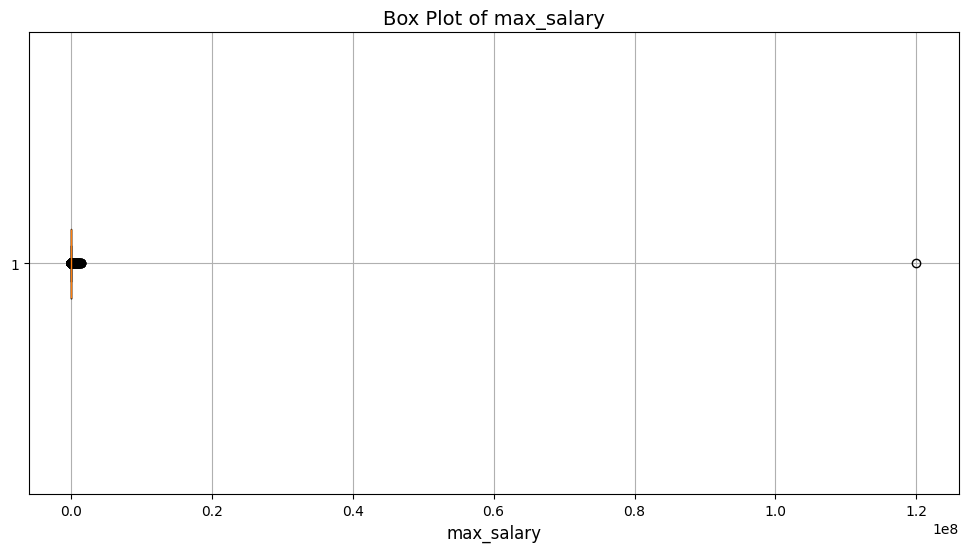

In [25]:
plot_box(df, 'max_salary')


<ipython-input-24-a64b64f51b54>:9: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')


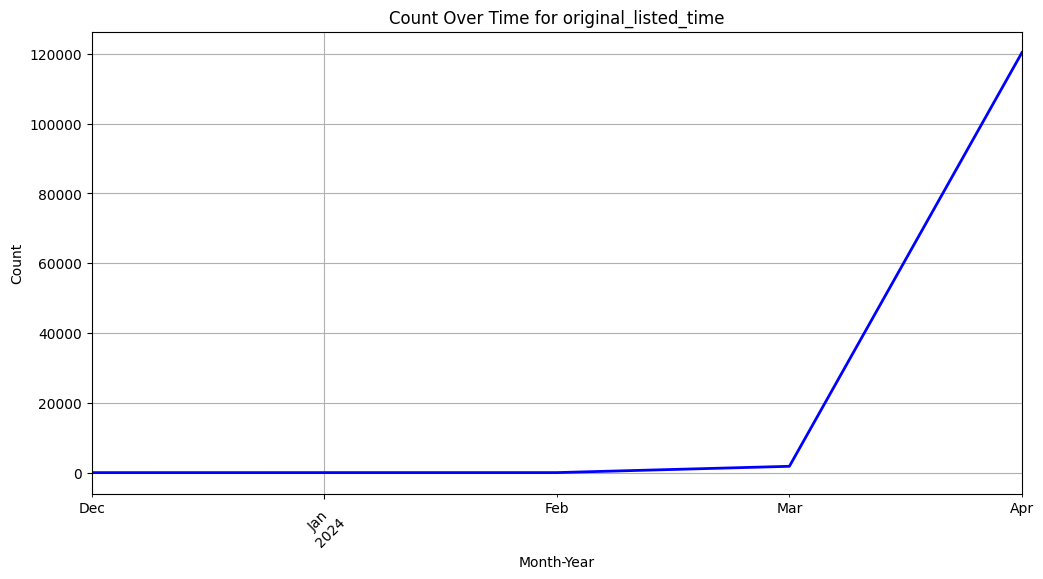

In [26]:
plot_time_series(df, 'original_listed_time')

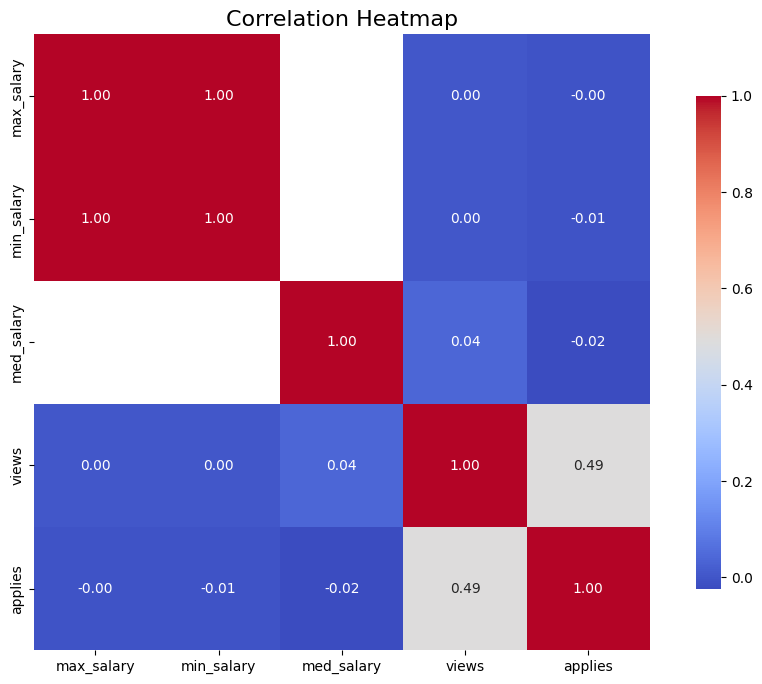

In [27]:
plot_heatmap(df, ['max_salary', 'min_salary', 'med_salary', 'views', 'applies'])

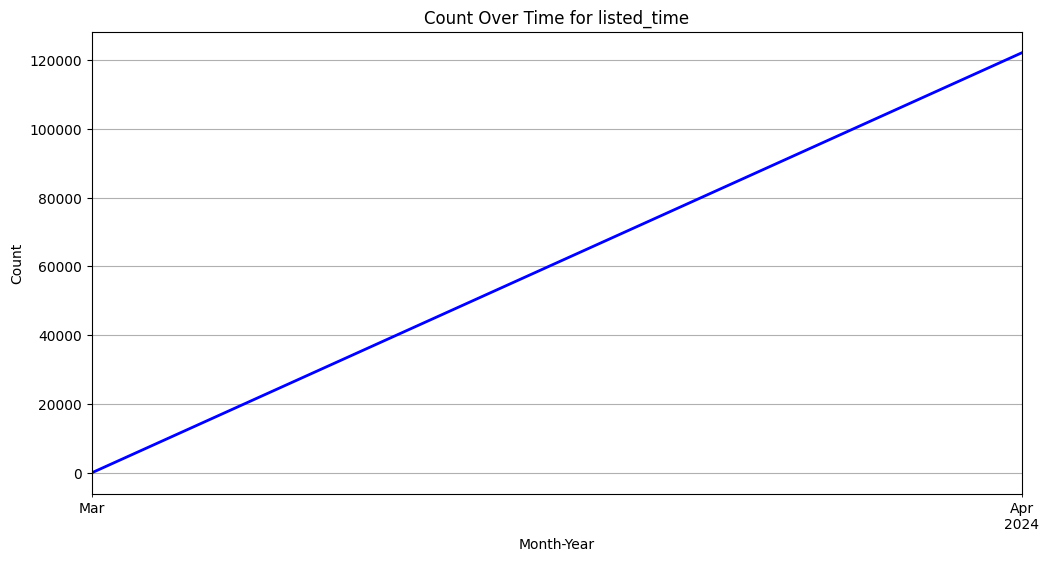

In [28]:
#Plot: Count of job postings over time. Time needs to be converted
plot_time_series(df, 'listed_time')


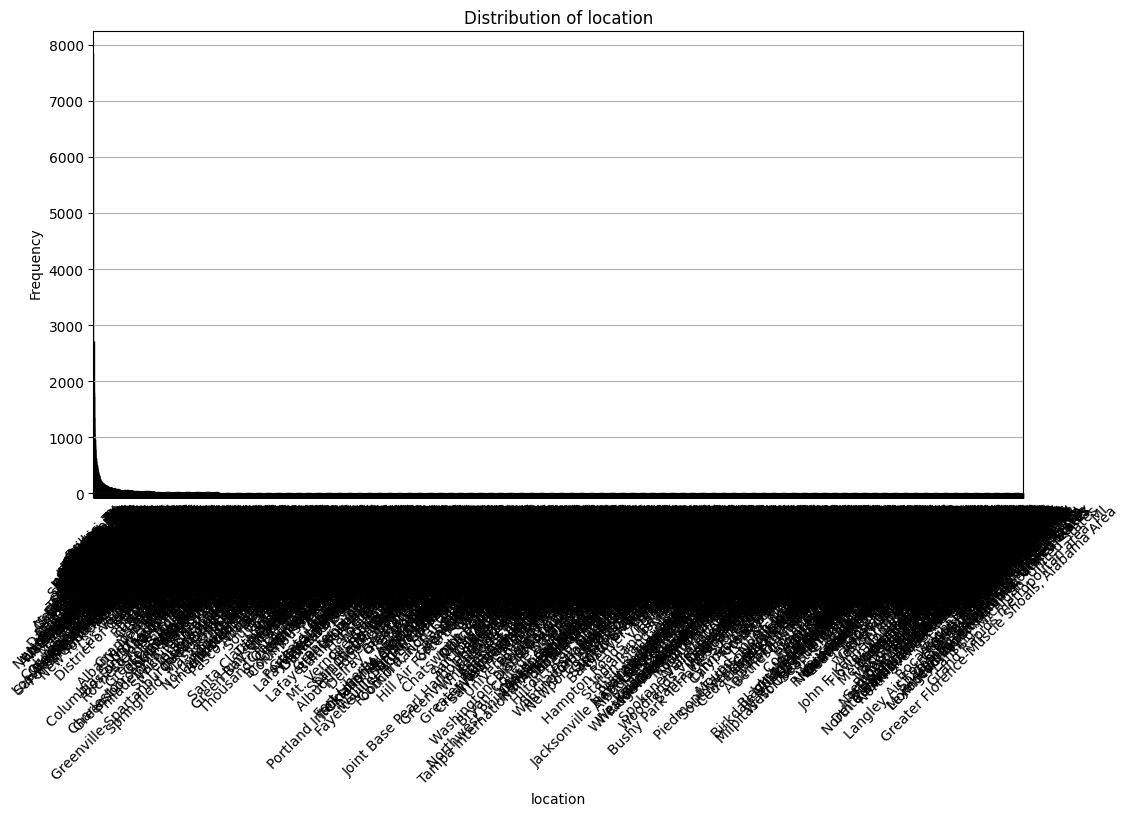

In [29]:
plot_bar(df, 'location')


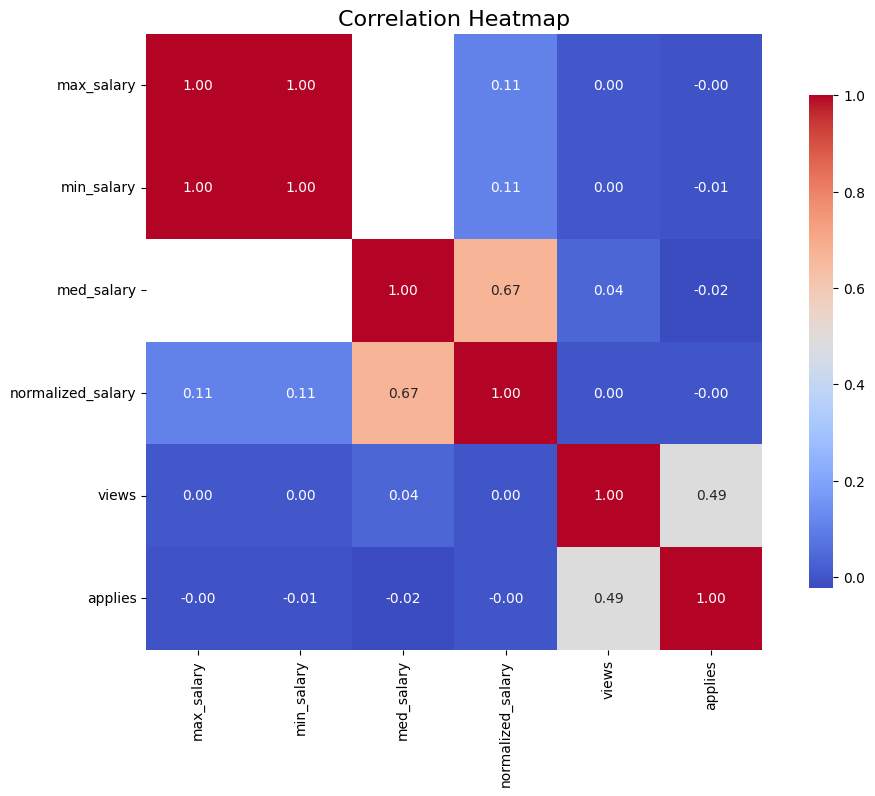

In [30]:
plot_heatmap(df, ['max_salary', 'min_salary', 'med_salary', 'normalized_salary', 'views', 'applies'])


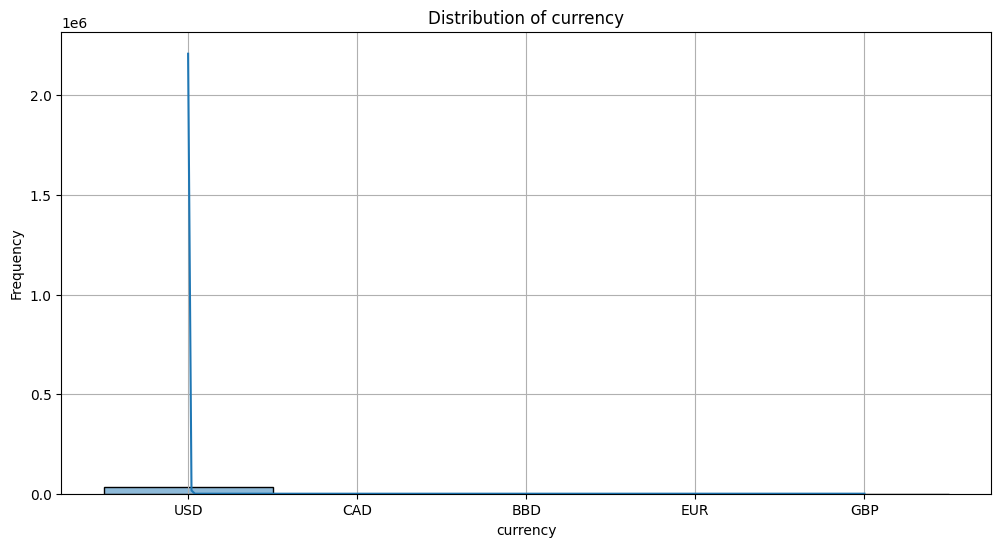

In [31]:
plot_distribution(df, 'currency')


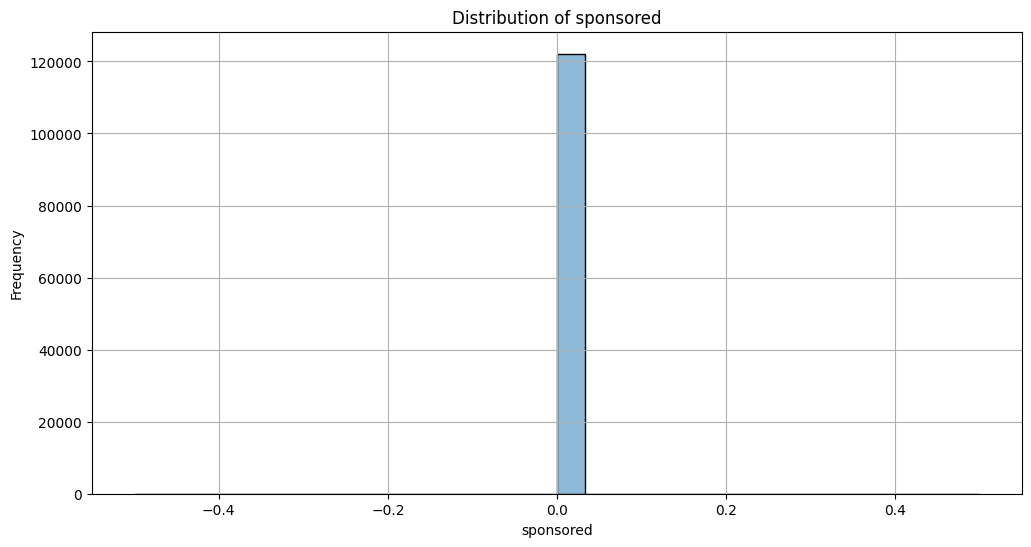

In [32]:
plot_distribution(df, 'sponsored')

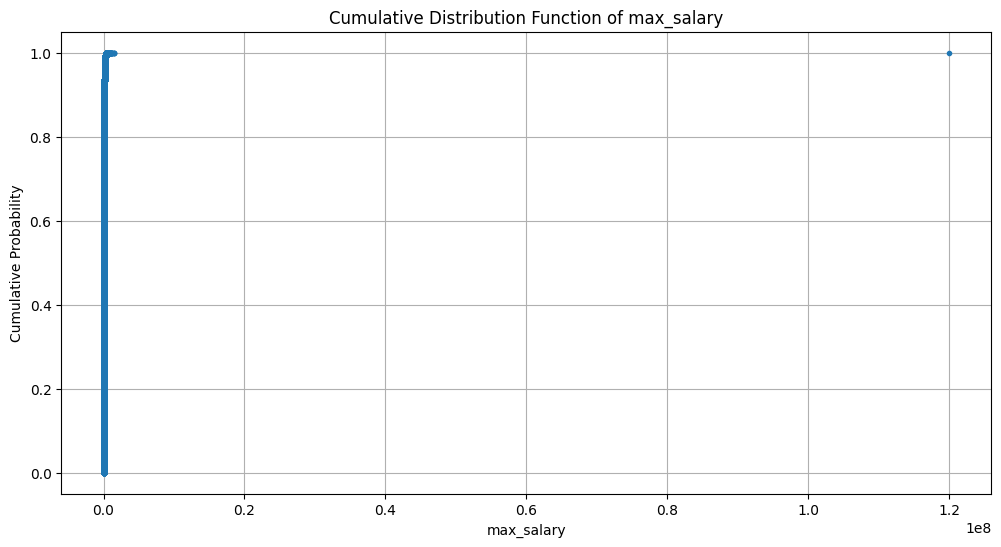

In [33]:
plot_cdf(df, 'max_salary')


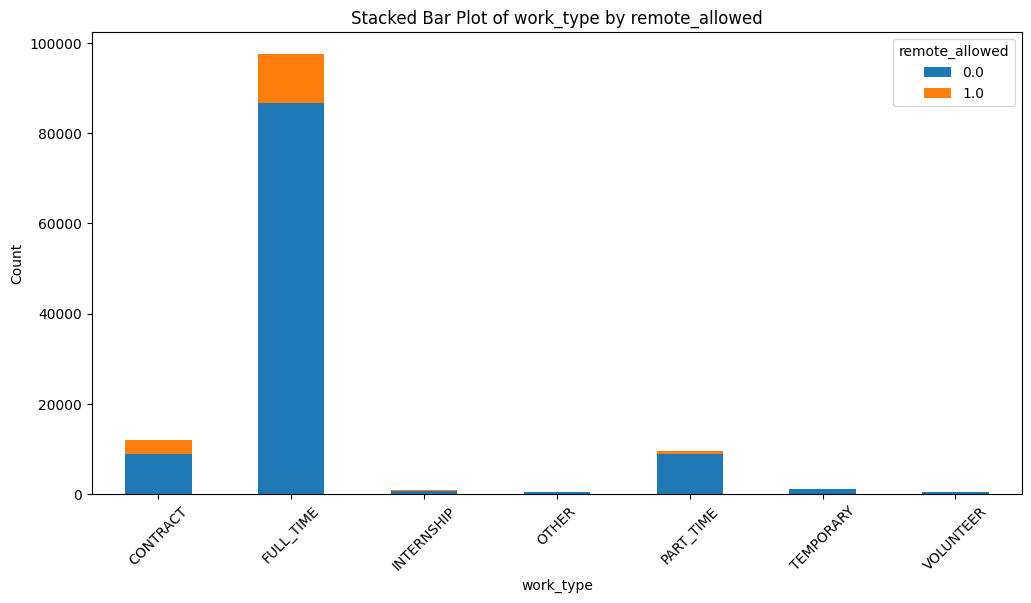

In [34]:
plot_stacked_bar(df, 'work_type', 'remote_allowed')


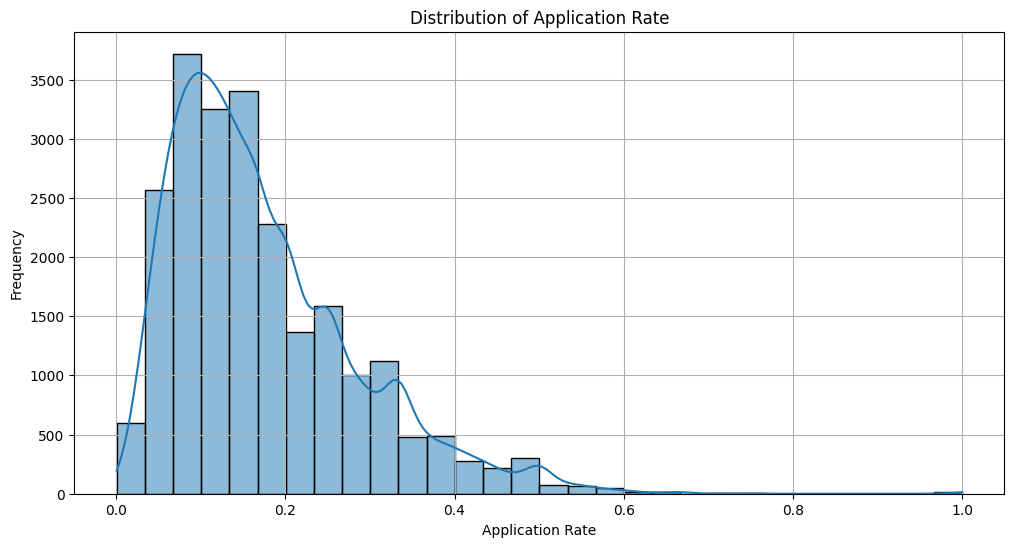

In [36]:
df['application_rate'] = df['applies'] / df['views']

def plot_application_rate(df):
    plt.figure(figsize=(12, 6))
    sns.histplot(df['application_rate'].dropna(), bins=30, kde=True)
    plt.title('Distribution of Application Rate')
    plt.xlabel('Application Rate')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()

# Example usage
plot_application_rate(df)

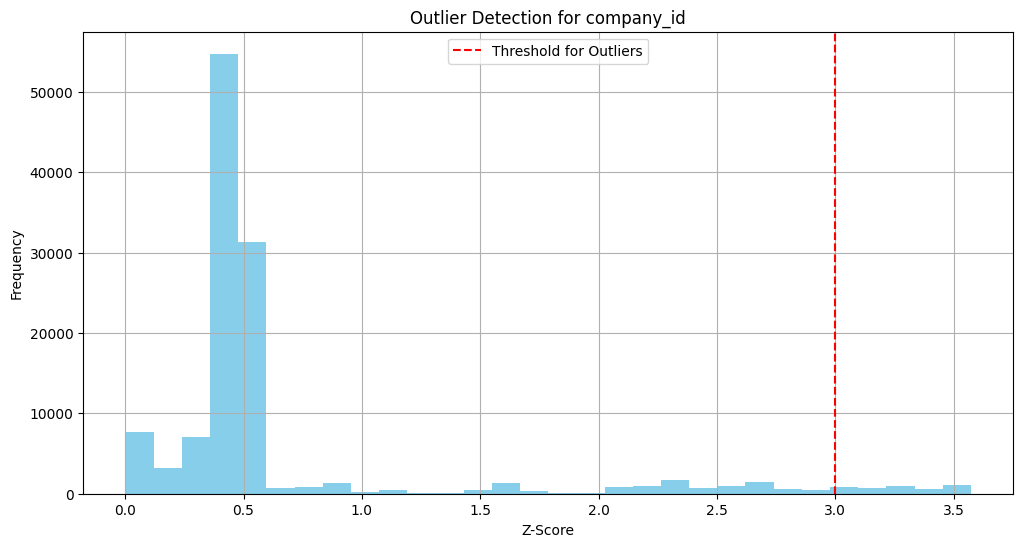

In [38]:
from scipy import stats

def plot_outliers(df, column):
    z_scores = np.abs(stats.zscore(df[column].dropna()))
    plt.figure(figsize=(12, 6))
    plt.hist(z_scores, bins=30, color='skyblue')
    plt.axvline(3, color='red', linestyle='--', label='Threshold for Outliers')
    plt.title(f'Outlier Detection for {column}')
    plt.xlabel('Z-Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid()
    plt.show()

# Example usage
plot_outliers(df, 'company_id')

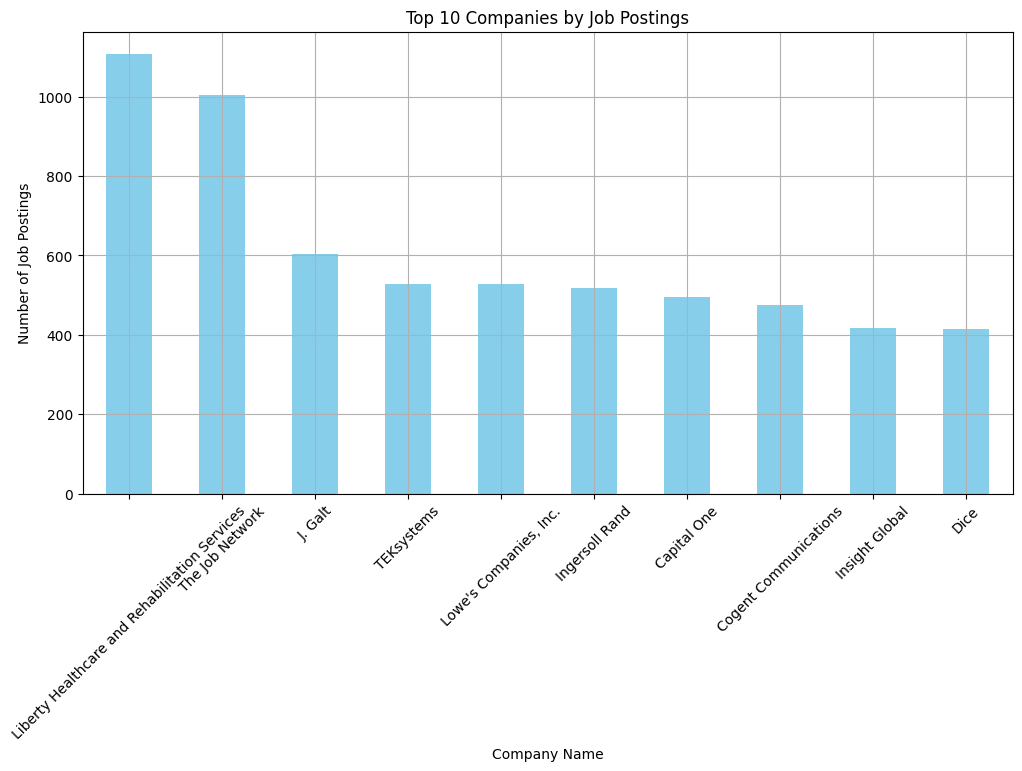

In [41]:
def plot_top_companies(df, column, title):
    top_companies = df[column].value_counts().nlargest(10)
    plt.figure(figsize=(12, 6))
    top_companies.plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel('Company Name')
    plt.ylabel('Number of Job Postings')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

plot_top_companies(df, 'company_name', 'Top 10 Companies by Job Postings')


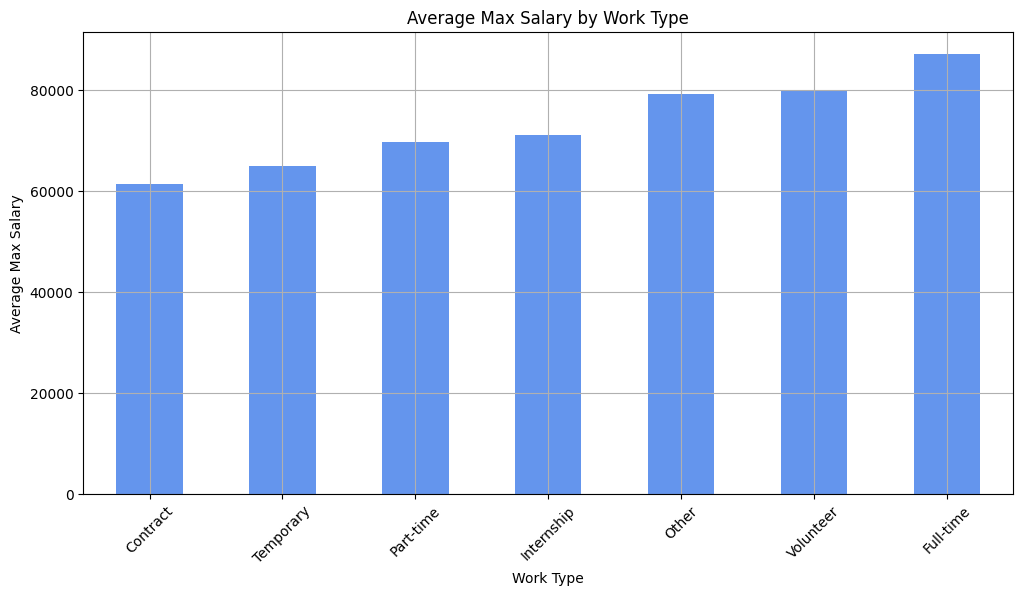

In [43]:
def plot_salary_by_work_type(df, title):
    plt.figure(figsize=(12, 6))
    df.groupby('formatted_work_type')['max_salary'].mean().sort_values().plot(kind='bar', color='cornflowerblue')
    plt.title(title)
    plt.xlabel('Work Type')
    plt.ylabel('Average Max Salary')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

plot_salary_by_work_type(df, 'Average Max Salary by Work Type')


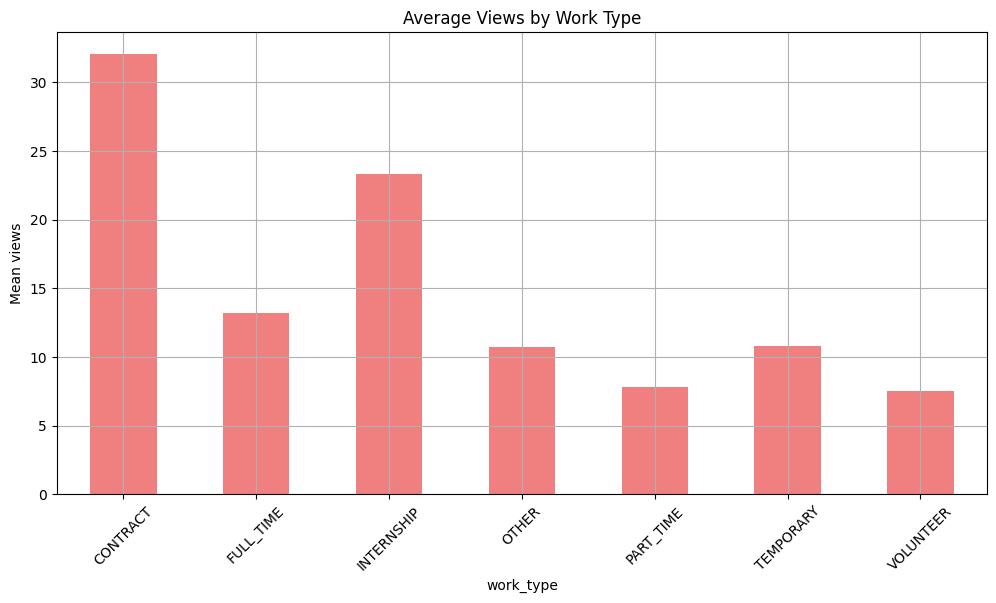

In [44]:
def plot_grouped_bar(df, category_col, value_col, title):
    plt.figure(figsize=(12, 6))
    df.groupby(category_col)[value_col].mean().plot(kind='bar', color='lightcoral')
    plt.title(title)
    plt.xlabel(category_col)
    plt.ylabel(f'Mean {value_col}')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()


plot_grouped_bar(df, 'work_type', 'views', 'Average Views by Work Type')
